In [21]:
import matplotlib.pyplot as plt
from random import randint

from torch_geometric.datasets import Entities, Planetoid
from torch_geometric.explain import Explainer, GNNExplainer, PGExplainer, DummyExplainer

import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx

import torch
import torch.nn.functional as F

from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.explain.metric import fidelity, unfaithfulness

**Data**

In [2]:
dataset = Planetoid(".", "Cora")
data = dataset[0]

**Model**

In [3]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)


model = GCN()

**Training**

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

**Eplainers**

In [14]:
gnnexplainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='phenomenon',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)


pgexplainer = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=200),
    explanation_type='phenomenon',
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)


dummyexplainer = Explainer(
    model=model,
    algorithm=DummyExplainer(),
    explanation_type='phenomenon',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

**Training Explainers**

In [ ]:
#train PGExplainer
for epoch in range(200):
    num_nodes = randint(0,1000)
    for node_index in range(num_nodes, num_nodes+200):  
        loss = pgexplainer.algorithm.train(epoch, model, data.x, data.edge_index, target=data.y, index=node_index)
    print(f"Loss {loss} in epoch {epoch}")

**Probing Explainers**

In [26]:
gnnexplainer_Unfaithfulness = []
pgexplainer_Unfaithfulness = []
dummyepxplainer_Unfaithfulness = []
#Calculate unfaithfulness for first n nodes
for node_index in range(0,20):    
    gnnexplanation = gnnexplainer(data.x, data.edge_index, index=node_index, target=data.y)
    gnn_unf = unfaithfulness(gnnexplainer, gnnexplanation)
    
    pgexplanation = pgexplainer(data.x, data.edge_index, index=node_index, target=data.y)
    pg_unf = unfaithfulness(pgexplainer, pgexplanation)
    
    dummyexplanation = dummyexplainer(data.x, data.edge_index, index=node_index, target=data.y)
    dummy_unf = unfaithfulness(dummyexplainer, dummyexplanation)
    
    gnnexplainer_Unfaithfulness.append(gnn_unf)
    pgexplainer_Unfaithfulness.append(pg_unf)
    dummyepxplainer_Unfaithfulness.append(dummy_unf)
    
    print(f"GNNExplainer unfaithfulness: {gnn_unf}")
    print(f"PGExplainer unfaithfulness: {pg_unf}")
    print(f"DummyExplainer unfaithfulness: {dummy_unf} \n\n")

GNNExplainer unfaithfulness: 0.015541791915893555
PGExplainer unfaithfulness: 0.6246781349182129
DummyExplainer unfaithfulness: 0.23606103658676147 


GNNExplainer unfaithfulness: 0.013374388217926025
PGExplainer unfaithfulness: 0.817513570189476
DummyExplainer unfaithfulness: 0.4286598563194275 


GNNExplainer unfaithfulness: 0.028753459453582764
PGExplainer unfaithfulness: 0.7250759303569794
DummyExplainer unfaithfulness: 0.462482750415802 


GNNExplainer unfaithfulness: 0.037793755531311035
PGExplainer unfaithfulness: 0.34917718172073364
DummyExplainer unfaithfulness: 0.2654034495353699 


GNNExplainer unfaithfulness: 0.02279454469680786
PGExplainer unfaithfulness: 0.5799050331115723
DummyExplainer unfaithfulness: 0.4689701199531555 


GNNExplainer unfaithfulness: 0.02457141876220703
PGExplainer unfaithfulness: 0.7456392645835876
DummyExplainer unfaithfulness: 0.23639929294586182 


GNNExplainer unfaithfulness: 0.04914790391921997
PGExplainer unfaithfulness: 0.5024809241294861
Dummy

Text(0.5, 1.0, 'Unfaitfulness on Dataset Cora')

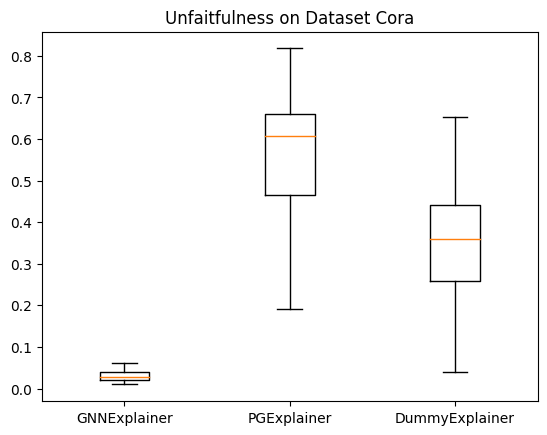

In [27]:
plt.boxplot([gnnexplainer_Unfaithfulness, pgexplainer_Unfaithfulness , dummyepxplainer_Unfaithfulness],labels=["GNNExplainer","PGExplainer","DummyExplainer"])
plt.title(f"Unfaitfulness on Dataset {dataset.name}")